In [1]:
import dowel_wrapper
import os
import pickle
import torch
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from envs.mujoco.ant_env import AntEnv
import io
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import scipy

2024-08-07 10:41:30.759657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 10:41:30.937734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 10:41:30.943978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /lib64:anonymous-anonymous/miniconda3/lib/::/u/anonymous/.mujoco/mujoco210/bin:/usr/lib/nvidia
2

In [15]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_models(chkpt):
    # 1. Load Metra weights
    METRA_EXP_ROOT = 'exp/ant_metra_sum_turn_off_dones_with_goal_metrics/sd000_s_21497671.0.1722112978_ant_metra'
    with open(os.path.join(METRA_EXP_ROOT, f'itr_10000.pkl'), 'rb') as f:
        metra_itr = CPU_Unpickler(f).load()

    metra_algo = metra_itr['algo']
    metra_algo.device = 'cpu'
    metra_algo.option_policy._module.to('cpu')

    metra_traj_data = torch.load(os.path.join(METRA_EXP_ROOT, f'traj_encoder{chkpt}.pt'), map_location=torch.device('cpu'))
    metra_traj_encoder = metra_traj_data['traj_encoder']
    metra_traj_encoder.to('cpu')
    metra_traj_encoder.eval()

    metra_option_data = torch.load(os.path.join(METRA_EXP_ROOT, f'option_policy{chkpt}.pt'), map_location=torch.device('cpu'))
    metra_option_policy = metra_option_data['policy']
    metra_option_policy.to('cpu')
    metra_option_policy.eval()

    # 2. Load Metra SF TD weights
#     METRA_SF_TD_EXP_ROOT = 'exp/ant_metra_sum_sf_td_no_done_with_goal_metrics/sd000_s_21511507.0.1722271692_ant_metra_sf'
    METRA_SF_TD_EXP_ROOT = 'exp/ant_metra_sum_sf_td_energy_no_done_with_goal_metrics/sd000_s_21565968.0.1722869139_ant_metra_sf'
#     METRA_SF_TD_EXP_ROOT = 'exp/ant_metra_sum_sf_td_energy_no_done_with_goal_metrics_lam_sweep/sd000_s_21567111.0.1722950266_ant_metra_sf'
    with open(os.path.join(METRA_SF_TD_EXP_ROOT, f'itr_10000.pkl'), 'rb') as f:
        metra_sf_td_itr = CPU_Unpickler(f).load()

    metra_sf_td_algo = metra_sf_td_itr['algo']
    metra_sf_td_algo.device = 'cpu'
    metra_sf_td_algo.option_policy._module.to('cpu')

    metra_sf_td_traj_data = torch.load(os.path.join(METRA_SF_TD_EXP_ROOT, f'traj_encoder{chkpt}.pt'), map_location=torch.device('cpu'))
    metra_sf_td_traj_encoder = metra_sf_td_traj_data['traj_encoder']
    metra_sf_td_traj_encoder.to('cpu')
    metra_sf_td_traj_encoder.eval()

    metra_sf_td_option_data = torch.load(os.path.join(METRA_SF_TD_EXP_ROOT, f'option_policy{chkpt}.pt'), map_location=torch.device('cpu'))
    metra_sf_td_option_policy = metra_sf_td_option_data['policy']
    metra_sf_td_option_policy.to('cpu')
    metra_sf_td_option_policy.eval()
    
    return metra_algo, metra_traj_encoder, metra_option_policy, metra_sf_td_algo, metra_sf_td_traj_encoder, metra_sf_td_option_policy

CHKPT = 40_000
metra_algo, metra_traj_encoder, metra_option_policy, metra_sf_td_algo, metra_sf_td_traj_encoder, metra_sf_td_option_policy = load_models(CHKPT)

In [16]:
from garagei.experiment.option_local_runner import OptionLocalRunner
from garaged.src.garage.experiment.experiment import ExperimentContext
from garagei.sampler.option_multiprocessing_sampler import OptionMultiprocessingSampler

def make_env():
    from iod.utils import get_normalizer_preset
    from garagei.envs.consistent_normalized_env import consistent_normalize
    # from envs.mujoco.ant_env import AntEnv
    from envs.mujoco.ant_env import AntEnv
    env = AntEnv(render_hw=100)

    normalizer_name = 'ant'
    normalizer_type = 'preset'
    normalizer_kwargs = {}
    if normalizer_type == 'off':
        env = consistent_normalize(env, normalize_obs=False, **normalizer_kwargs)
    else:
        normalizer_mean, normalizer_std = get_normalizer_preset(f'{normalizer_name}_preset')
        env = consistent_normalize(env, normalize_obs=True, mean=normalizer_mean, std=normalizer_std, **normalizer_kwargs)

    return env

env = make_env()
contextualized_make_env = make_env

# Setup runners
metra_runner = OptionLocalRunner(ExperimentContext(
    snapshot_dir='.',
    snapshot_mode='last',
    snapshot_gap=1,
))

metra_runner.setup(
    algo=metra_algo,
    env=env,
    make_env=contextualized_make_env,
    sampler_cls=OptionMultiprocessingSampler,
    sampler_args=dict(n_thread=1),
    n_workers=1,
)

metra_sf_td_runner = OptionLocalRunner(ExperimentContext(
    snapshot_dir='.',
    snapshot_mode='last',
    snapshot_gap=1,
))

metra_sf_td_runner.setup(
    algo=metra_algo,
    env=env,
    make_env=contextualized_make_env,
    sampler_cls=OptionMultiprocessingSampler,
    sampler_args=dict(n_thread=1),
    n_workers=1,
)

Metra SF TD {'GoalDistance': 31.409866832108243, 'GoalSquaredDistance': 2348.7581523403965, 'GoalHitSuccessRate': 0.525, 'GoalStaySuccessRate': 0.075, 'GoalStayingTime': 46.625}


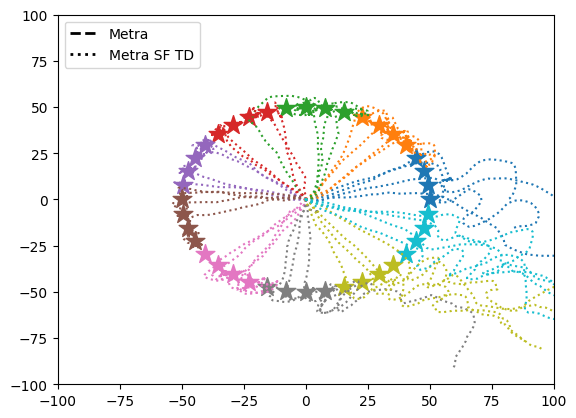

In [17]:
# COLLECT GOALS INTO A LIST
def collect_goals(env, goal_range: float = 50, num_goals: int = 1):
    goals = []  # list of (goal_obs, goal_info)
    for i in range(num_goals):
        env.reset()
        state = env.unwrapped._get_obs().copy()
#         goal_loc = (np.random.rand(2) * 2 - 1) * goal_range
        goal_loc = (goal_range * np.cos(i * 2 * np.pi / num_goals), goal_range * np.sin(i * 2 * np.pi / num_goals))
        state[:2] = goal_loc
        env.set_state(state[:15], state[15:])

        for _ in range(5):
            env.step(np.zeros_like(env.action_space.sample()))

        goal_obs = env._apply_normalize_obs(state).astype(np.float32)
        goals.append((goal_obs, {'goal_loc': goal_loc}))
    
    return goals

def evaluate_goals(goals, traj_encoder, option_policy, label: str, ax, cmap):
    eval_option_metrics = {}
    goal_metrics = defaultdict(list)
    mean_length = 1.
    goal_radius = 1.
    for i, (goal_obs, goal_info) in enumerate(goals):
        obs = env.reset()
        step = 0
        done = False
        hit_success = 0
        stay_success = 0
        option = None
        staying_time = 0
        xs = [env.unwrapped._get_obs()[0]]
        ys = [env.unwrapped._get_obs()[1]]
        while step < 1000 and not done:
            te_input = torch.from_numpy(np.stack([obs, goal_obs])).to('cpu')
            phi_s, phi_g = traj_encoder(te_input).mean
            phi_s, phi_g = phi_s.detach().cpu().numpy(), phi_g.detach().cpu().numpy()
            option = (phi_g - phi_s) / np.linalg.norm(phi_g - phi_s) * mean_length

            action, agent_info = option_policy.get_action(np.concatenate([obs, option]))
            next_obs, _, done, info = env.step(action)
            obs = next_obs

            step += 1
            xs.append(env.unwrapped._get_obs()[0])
            ys.append(env.unwrapped._get_obs()[1])
            
            if np.linalg.norm(env.unwrapped._get_obs()[:2] - goal_info['goal_loc']) < goal_radius:
                hit_success = 1.
                staying_time += 1.
       
        if np.linalg.norm(env.unwrapped._get_obs()[:2] - goal_info['goal_loc']) < goal_radius:
            stay_success = 1.
        cur_loc = env.unwrapped._get_obs()[:2]
        distance = np.linalg.norm(cur_loc - goal_info['goal_loc'])
        squared_distance = distance ** 2
        goal_metrics[f'GoalDistance'].append(distance)
        goal_metrics[f'GoalSquaredDistance'].append(squared_distance)
        goal_metrics[f'GoalHitSuccessRate'].append(hit_success)
        goal_metrics[f'GoalStaySuccessRate'].append(stay_success)
        goal_metrics[f'GoalStayingTime'].append(staying_time)
        
        if ax is not None:
            ax.plot(xs, ys, label=label, color=cmap(i), linestyle='dashed' if label=='Metra' else 'dotted')

    goal_metrics = {key: np.mean(value) for key, value in goal_metrics.items()}
    eval_option_metrics.update(goal_metrics)
    
    return eval_option_metrics

goals = collect_goals(metra_runner._env, goal_range=50, num_goals=40)

# 1. plot the goals
fig, ax = plt.subplots()
num_goals = len(goals)
cmap = cm.get_cmap('tab10', num_goals)
for i, (_, goal_info) in enumerate(goals):
    x, y = goal_info['goal_loc']
    ax.scatter(x, y, color=cmap(i), marker='*', s=200)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
    
# metra_metrics = evaluate_goals(goals, metra_traj_encoder, metra_option_policy, 'Metra', ax, cmap)
metra_sf_td_metrics = evaluate_goals(goals, metra_sf_td_traj_encoder, metra_sf_td_option_policy, 'Metra SF TD', ax, cmap)

# print('Metra', metra_metrics)
print('Metra SF TD', metra_sf_td_metrics)
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='dashed', label='Metra'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted', label='Metra SF TD')
]
ax.legend(handles=legend_elements, loc='upper left')
plt.show()


In [13]:
NUM_GOALS = 200
goals = collect_goals(metra_runner._env, num_goals=NUM_GOALS)

In [14]:
xs = []
t = scipy.stats.t.isf(0.025, df=NUM_GOALS-1)
print('t', t)
metra_hit_success_mean = []
metra_hit_success_se = []
metra_stay_success_mean = []
metra_stay_success_se = []

metra_sf_td_hit_success_mean = []
metra_sf_td_hit_success_se = []
metra_sf_td_stay_success_mean = []
metra_sf_td_stay_success_se = []

metra_relabel_actor_z_hit_success_mean = []
metra_relabel_actor_z_hit_success_se = []
metra_relabel_actor_z_stay_success_mean = []
metra_relabel_actor_z_stay_success_se = []

for chkpt in [1000, 5000, 10_000, 15_000, 20_000, 30_000]:
    print('rolling out checkpoint', chkpt)
    xs.append(chkpt)
    metra_algo, metra_traj_encoder, metra_option_policy, metra_sf_td_algo, metra_sf_td_traj_encoder, metra_sf_td_option_policy, metra_relabel_actor_z_algo, metra_relabel_actor_z_traj_encoder, metra_relabel_actor_z_option_policy = load_models(chkpt)
    metra_metrics = evaluate_goals(goals, metra_traj_encoder, metra_option_policy, 'Metra', None, None)
    metra_sf_td_metrics = evaluate_goals(goals, metra_sf_td_traj_encoder, metra_sf_td_option_policy, 'Metra SF TD', None, None)
    metra_relabel_actor_z_metrics = evaluate_goals(goals, metra_relabel_actor_z_traj_encoder, metra_relabel_actor_z_option_policy, 'Metra Actor Relabel Z', None, None)
    
    metra_hit_success_mean.append(np.mean(metra_metrics['GoalHitSuccessRate']))
    metra_hit_success_se.append(t * scipy.stats.sem(metra_metrics['GoalHitSuccessRate']))
    metra_stay_success_mean.append(np.mean(metra_metrics['GoalStaySuccessRate']))
    metra_stay_success_se.append(t * scipy.stats.sem(metra_metrics['GoalStaySuccessRate']))
    
    metra_sf_td_hit_success_mean.append(np.mean(metra_sf_td_metrics['GoalHitSuccessRate']))
    metra_sf_td_hit_success_se.append(t * scipy.stats.sem(metra_sf_td_metrics['GoalHitSuccessRate']))
    metra_sf_td_stay_success_mean.append(np.mean(metra_sf_td_metrics['GoalStaySuccessRate']))
    metra_sf_td_stay_success_se.append(t * scipy.stats.sem(metra_sf_td_metrics['GoalStaySuccessRate']))
    
    metra_relabel_actor_z_hit_success_mean.append(np.mean(metra_relabel_actor_z_metrics['GoalHitSuccessRate']))
    metra_relabel_actor_z_hit_success_se.append(t * scipy.stats.sem(metra_relabel_actor_z_metrics['GoalHitSuccessRate']))
    metra_relabel_actor_z_stay_success_mean.append(np.mean(metra_relabel_actor_z_metrics['GoalStaySuccessRate']))
    metra_relabel_actor_z_stay_success_se.append(t * scipy.stats.sem(metra_relabel_actor_z_metrics['GoalStaySuccessRate']))

t 1.9719565442493954
rolling out checkpoint 1000


ValueError: not enough values to unpack (expected 9, got 6)

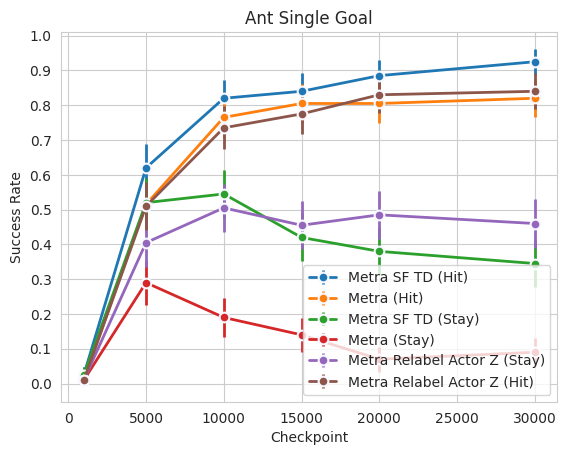

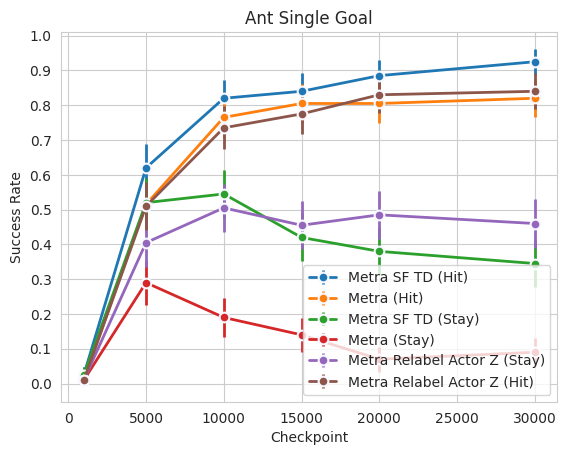

In [28]:
import seaborn as sns
sns.set_style("whitegrid")
# plot stuff
fig, ax = plt.subplots()
ax.errorbar(xs, metra_sf_td_hit_success_mean, label='Metra SF TD (Hit)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_sf_td_hit_success_se)
ax.errorbar(xs, metra_hit_success_mean, label='Metra (Hit)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_hit_success_se)
ax.errorbar(xs, metra_sf_td_stay_success_mean, label='Metra SF TD (Stay)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_sf_td_stay_success_se)
ax.errorbar(xs, metra_stay_success_mean, label='Metra (Stay)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_stay_success_se)
ax.errorbar(xs, metra_relabel_actor_z_stay_success_mean, label='Metra Relabel Actor Z (Stay)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_relabel_actor_z_stay_success_se)
ax.errorbar(xs, metra_relabel_actor_z_hit_success_mean, label='Metra Relabel Actor Z (Hit)', marker='o', markersize=7, markeredgewidth=1.5, markeredgecolor="#F7F7FF", linewidth=2, yerr=metra_relabel_actor_z_hit_success_se)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel('Checkpoint')
ax.set_ylabel('Success Rate')
ax.set_title('Ant Single Goal')
ax.legend()
plt.show()